In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import pandas as pd
from sklearn.cluster import KMeans

images_path = '/Users/joanna/datasci_281/final_project/HAM10000_images_preprocessed'
segmentation_path = '/Users/joanna/datasci_281/final_project/HAM10000_segmentations_lesion_tschandl'
metadata = pd.read_csv('HAM10000_metadata.csv')

In [ ]:
# get paths for image and segmentation files
img_files = sorted(glob.glob('/'.join([images_path, '*.jpg'])))
segmentation_files = sorted(glob.glob('/'.join([segmentation_path, '*.png'])))
# get the image ID
img_files_df = pd.DataFrame({'img_file_path': img_files})
img_files_df['image_id'] = img_files_df['img_file_path'].apply(lambda x: x.split('/')[-1].replace('.jpg', ''))
# get the segmentation ID
segmentation_files_df = pd.DataFrame({'segmentation_file_path': segmentation_files})
segmentation_files_df['image_id'] = segmentation_files_df['segmentation_file_path'].apply(lambda x: x.split('/')[-1].replace('_segmentation.png', ''))

In [ ]:
# merge the dataframes to make one metadata file
metadata = pd.merge(metadata, img_files_df, left_on= 'image_id', right_on = 'image_id')
metadata = pd.merge(metadata, segmentation_files_df, left_on = 'image_id', right_on = 'image_id')

metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,img_file_path,segmentation_file_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,/Users/joanna/datasci_281/final_project/HAM100...,/Users/joanna/datasci_281/final_project/HAM100...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,/Users/joanna/datasci_281/final_project/HAM100...,/Users/joanna/datasci_281/final_project/HAM100...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,/Users/joanna/datasci_281/final_project/HAM100...,/Users/joanna/datasci_281/final_project/HAM100...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,/Users/joanna/datasci_281/final_project/HAM100...,/Users/joanna/datasci_281/final_project/HAM100...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,/Users/joanna/datasci_281/final_project/HAM100...,/Users/joanna/datasci_281/final_project/HAM100...


In [ ]:
# USED TO VISUALIZE DATA AND POSSIBLE TRENDS
# unique diagnoses
unique_dx = metadata['dx'].unique()
# dictionary to store the feature information
histograms_hue = {}
histograms_saturation = {}
histograms_value = {}

histograms_hue_average = {}
histograms_saturation_average = {}
histograms_value_average = {}

histograms_hue_median = {}
histograms_saturation_median = {}
histograms_value_median = {}
for dx in unique_dx:
    subset_df = metadata[metadata['dx'] == dx].reset_index()
    img_paths = subset_df['img_file_path']
    segmentation_paths = subset_df['segmentation_file_path']
    for i in range(len(subset_df)):
        img = cv2.imread(img_paths[i], cv2.IMREAD_COLOR)
        segmentation = cv2.imread(segmentation_paths[i], cv2.IMREAD_GRAYSCALE)

        hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        hist_hue = cv2.calcHist([hsv_image], [0], segmentation, [256], [0, 180])
        hist_saturation = cv2.calcHist([hsv_image], [1], segmentation, [256], [0, 256])
        hist_value = cv2.calcHist([hsv_image], [2], segmentation, [256], [0, 256])

        if dx not in histograms_hue.keys():
            histograms_hue[dx] = []
            histograms_saturation[dx] = []
            histograms_value[dx] = []
        histograms_hue[dx].append(hist_hue)
        histograms_saturation[dx].append(hist_saturation)
        histograms_value[dx].append(hist_value)
    histograms_hue_average[dx] = np.mean(np.array(histograms_hue[dx]), axis = 0)
    histograms_saturation_average[dx] = np.mean(np.array(histograms_saturation[dx]), axis = 0)
    histograms_value_average[dx] = np.mean(np.array(histograms_value[dx]), axis = 0)

    histograms_hue_median[dx] = np.median(np.array(histograms_hue[dx]), axis = 0)
    histograms_saturation_median[dx] = np.median(np.array(histograms_saturation[dx]), axis = 0)
    histograms_value_median[dx] = np.median(np.array(histograms_value[dx]), axis = 0)

In [ ]:
histograms_hue = {}
histograms_saturation = {}
histograms_value = {}

img_info = metadata[['image_id','img_file_path', 'segmentation_file_path']]
for i in range(len(metadata)):
    img = cv2.imread(img_info['img_file_path'].iloc[i], cv2.IMREAD_COLOR)
    segmentation = cv2.imread(img_info['segmentation_file_path'].iloc[i], cv2.IMREAD_GRAYSCALE)

    hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    histograms_hue[img_info['image_id'].iloc[i]] = cv2.calcHist([hsv_image], [0], segmentation, [256], [0, 180]).flatten().tolist()
    histograms_saturation[img_info['image_id'].iloc[i]] = cv2.calcHist([hsv_image], [1], segmentation, [256], [0, 256]).flatten().tolist()
    histograms_value[img_info['image_id'].iloc[i]] = cv2.calcHist([hsv_image], [2], segmentation, [256], [0, 256]).flatten().tolist()

In [ ]:
histograms_hue_df = pd.DataFrame(list(histograms_hue.items()), columns=['image_id', 'hue_histogram'])
histograms_saturation_df = pd.DataFrame(list(histograms_saturation.items()), columns=['image_id', 'saturation_histogram'])
histograms_value_df = pd.DataFrame(list(histograms_value.items()), columns=['image_id', 'value_histogram'])

In [ ]:
histogram_HSV_df = pd.merge(histograms_hue_df, histograms_saturation_df)
histogram_HSV_df = pd.merge(histogram_HSV_df, histograms_value_df)

In [ ]:
histogram_HSV_df.to_csv('histogram_HSV.csv')

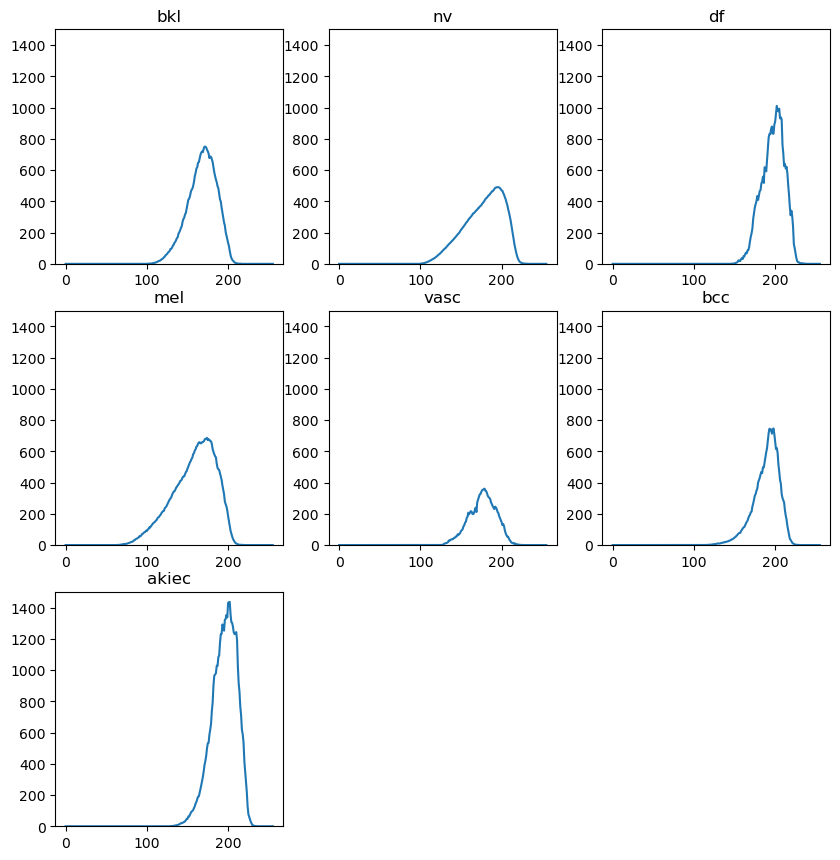

In [ ]:
# creates plot for averages
fig, axs = plt.subplots(4, 3, figsize=(10, 14))
axs = axs.flatten()
i = 0
for key in histograms_value_median.keys():
    axs[i].plot(histograms_value_median[key])
    axs[i].set_title(key)
    axs[i].set_ylim([0,1500])
    i += 1

for j in range(7, 12):
    fig.delaxes(axs[j])

In [ ]:
# finds the kmeans clustering
unique_dx = metadata['dx'].unique()
dx_pixel_average = pd.DataFrame()
dx_pixel_centers = pd.DataFrame()
for dx in unique_dx:
    subset_df = metadata[metadata['dx'] == dx].reset_index()
    cluster_centers = {'cluster1':[], 'cluster2':[], 'cluster3':[]}
    img_paths = subset_df['img_file_path']
    segmentation_paths = subset_df['segmentation_file_path']
    for i in range(len(subset_df)):
        img = cv2.imread(img_paths[i], cv2.IMREAD_COLOR)
        segmentation = cv2.imread(segmentation_paths[i], cv2.IMREAD_GRAYSCALE)

        segmentation_mask = np.repeat(segmentation[:, :, np.newaxis], 3, axis=2)
        img_filtered = cv2.bitwise_and(img, segmentation_mask)
        img_hsv = cv2.cvtColor(img_filtered, cv2.COLOR_BGR2HSV)

        pixels = img_hsv[segmentation_mask > 0].reshape(-1,3)

        kmeans = KMeans(n_clusters=2, random_state=0).fit(pixels)
        centers = sorted(kmeans.cluster_centers_[:,0])

        cluster_centers['cluster1'].append(centers[0])
        cluster_centers['cluster2'].append(centers[1])
    dx_pixel_average[dx] = {'cluster1': sum(cluster_centers['cluster1'])/len(cluster_centers['cluster1']),
                            'cluster2': sum(cluster_centers['cluster2'])/len(cluster_centers['cluster2']),}
    dx_pixel_centers[dx] = {'cluster1': cluster_centers['cluster1'],
                            'cluster2': cluster_centers['cluster2'],}


In [ ]:
dx_pixel_average

,bkl,nv,df,mel,vasc,bcc,akiec
cluster1,22.174724,21.909879,36.507251,17.905925,133.919333,45.755518,19.819622
cluster2,158.368386,143.606109,171.261794,154.145309,165.004941,161.930765,160.184311
